In [1]:
import os
import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
import ast
from tqdm import tqdm


# Configuration
AUDIO_DIR = "birdclef-2025/train_audio"
CSV_PATH = "birdclef-2025/train.csv"
PREPROCESSED_DIR = "preprocessed_segments"
SAMPLE_RATE = 32000
N_MELS = 128
DURATION = 5  # seconds
NUM_CLASSES = 206
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Ensure output directory exists
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

# Load and map labels
df = pd.read_csv(CSV_PATH)
all_labels = sorted(df["primary_label"].unique())
label2idx = {label: idx for idx, label in enumerate(all_labels)}

# Mel transforms
mel_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=320,
    n_mels=N_MELS
)
db_transform = T.AmplitudeToDB()
preprocess = False
if preprocess:
    # Preprocessing loop
    segments = []
    for _, row in tqdm(df.iterrows()):
        fname = row["filename"]
        file_path = os.path.join(AUDIO_DIR, fname)
        if not os.path.exists(file_path):
            continue

        try:
            waveform, sr = torchaudio.load(file_path)
            if sr != SAMPLE_RATE:
                resampler = T.Resample(sr, SAMPLE_RATE)
                waveform = resampler(waveform)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            total_len = waveform.shape[1]
            step = DURATION * SAMPLE_RATE
            num_chunks = total_len // step

            for i in range(num_chunks):
                chunk = waveform[:, i*step : (i+1)*step]
                mel = mel_transform(chunk)
                mel_db = db_transform(mel)
                mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

                target = torch.zeros(NUM_CLASSES)
                if row["primary_label"] in label2idx:
                    target[label2idx[row["primary_label"]]] = 1.0
                try:
                    sec_list = ast.literal_eval(row["secondary_labels"])
                    for label in sec_list:
                        if label in label2idx:
                            target[label2idx[label]] = 1.0
                except:
                    pass

            base_name = fname.replace('/', '_').replace('.ogg', '')
            out_name = f"{base_name}_{i}.pt"
            out_path = os.path.join(PREPROCESSED_DIR, out_name)

            torch.save({"mel": mel_db, "target": target}, out_path)
            segments.append(out_name)



        except Exception as e:
            print(f"Error processing {fname}: {e}")
else:
    pass

In [2]:
import os
import torch
from torch.utils.data import Dataset

class PreprocessedBirdCLEFDataset(Dataset):
    def __init__(self, file_list, data_dir):
        self.file_list = file_list
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        sample_path = os.path.join(self.data_dir, self.file_list[idx])
        sample = torch.load(sample_path)
        return sample["mel"], sample["target"]


In [3]:
from sklearn.model_selection import train_test_split
import os

PREPROCESSED_DIR = "./preprocessed_segments"
all_files = [f for f in os.listdir(PREPROCESSED_DIR) if f.endswith(".pt")]

train_files, val_files = train_test_split(all_files, test_size=0.1, random_state=42)


In [4]:
train_dataset = PreprocessedBirdCLEFDataset(train_files, PREPROCESSED_DIR)
val_dataset = PreprocessedBirdCLEFDataset(val_files, PREPROCESSED_DIR)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


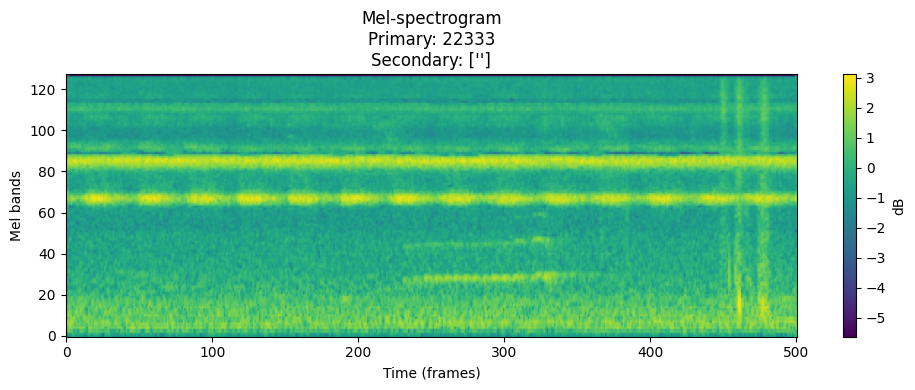

In [5]:
import matplotlib.pyplot as plt

mel, target = train_dataset[138]

mel_np = mel.squeeze().numpy()  

# Визуализация
plt.figure(figsize=(10, 4))
plt.imshow(mel_np, origin='lower', aspect='auto', cmap='viridis')
plt.title(f"Mel-spectrogram\nPrimary: {df.iloc[138]['primary_label']}\nSecondary: {df.iloc[138]['secondary_labels']}")
plt.xlabel("Time (frames)")
plt.ylabel("Mel bands")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()


In [6]:
import os, torch
bad = []
if preprocess:
    for f in os.listdir("preprocessed_segments"):
        x = torch.load(f"preprocessed_segments/{f}")
        if x["target"].shape[0] != 206:
            bad.append(f)
    print(f"Найдено {len(bad)} плохих файлов")

Найдено 0 плохих файлов


In [ ]:
import torch.nn as nn
import torch
from models.simplecnn import BirdCLEFClassifier, CNNEncoder
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BirdCLEFClassifier(CNNEncoder()).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
NUM_EPOCHS = 10
train_simple_cnn = False
if train_simple_cnn:
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch"):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc="Validation", unit="batch"):
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = criterion(preds, y)
                val_loss += loss.item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Validation: 100%|██████████| 90/90 [00:02<00:00, 31.21batch/s]


Epoch 1/10 | Train Loss: 0.0690 | Val Loss: 0.0311


Validation: 100%|██████████| 90/90 [00:02<00:00, 30.77batch/s]


Epoch 2/10 | Train Loss: 0.0312 | Val Loss: 0.0310


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.97batch/s]


Epoch 3/10 | Train Loss: 0.0309 | Val Loss: 0.0305


Validation: 100%|██████████| 90/90 [00:02<00:00, 30.94batch/s]


Epoch 4/10 | Train Loss: 0.0303 | Val Loss: 0.0300


Validation: 100%|██████████| 90/90 [00:02<00:00, 31.04batch/s]


Epoch 5/10 | Train Loss: 0.0297 | Val Loss: 0.0299


Validation: 100%|██████████| 90/90 [00:02<00:00, 31.20batch/s]


Epoch 6/10 | Train Loss: 0.0292 | Val Loss: 0.0291


Validation: 100%|██████████| 90/90 [00:02<00:00, 30.91batch/s]


Epoch 7/10 | Train Loss: 0.0287 | Val Loss: 0.0285


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.00batch/s]


Epoch 8/10 | Train Loss: 0.0281 | Val Loss: 0.0282


Validation: 100%|██████████| 90/90 [00:02<00:00, 31.38batch/s]


Epoch 9/10 | Train Loss: 0.0276 | Val Loss: 0.0277


Validation: 100%|██████████| 90/90 [00:02<00:00, 30.48batch/s]

Epoch 10/10 | Train Loss: 0.0272 | Val Loss: 0.0273


In [7]:
torch.save(model.state_dict(), "birdclef_deepcnn_preprocessed.pth")

In [5]:
import torch.nn as nn
import torch
from models.simplecnn import BirdCLEFClassifier, CNNEncoder
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
from models.birdresnet import BirdResNet

model = BirdResNet(num_classes=NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
NUM_EPOCHS = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch")
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validation", unit="batch"):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"✔️ Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    scheduler.step(val_loss)



e:\birdCLEF25\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\birdCLEF25\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Validation: 100%|██████████| 90/90 [00:03<00:00, 29.48batch/s]


✔️ Epoch 1: Train Loss = 0.0519, Val Loss = 0.0298


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.10batch/s]


✔️ Epoch 2: Train Loss = 0.0284, Val Loss = 0.0258


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.14batch/s]


✔️ Epoch 3: Train Loss = 0.0246, Val Loss = 0.0232


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.22batch/s]


✔️ Epoch 4: Train Loss = 0.0219, Val Loss = 0.0213


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.57batch/s]


✔️ Epoch 5: Train Loss = 0.0196, Val Loss = 0.0196


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.30batch/s]


✔️ Epoch 6: Train Loss = 0.0177, Val Loss = 0.0187


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.15batch/s]


✔️ Epoch 7: Train Loss = 0.0158, Val Loss = 0.0180


Validation: 100%|██████████| 90/90 [00:03<00:00, 28.67batch/s]


✔️ Epoch 8: Train Loss = 0.0139, Val Loss = 0.0189


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.61batch/s]


✔️ Epoch 9: Train Loss = 0.0120, Val Loss = 0.0184


Validation: 100%|██████████| 90/90 [00:03<00:00, 29.35batch/s]

✔️ Epoch 10: Train Loss = 0.0100, Val Loss = 0.0191
Epoch 00010: reducing learning rate of group 0 to 5.0000e-05.


In [9]:
# Save model
torch.save(model.state_dict(), "birdclef_resnet18_fixed.pth")

In [10]:
from models.birdefficientnet import BirdEfficientNet

model = BirdEfficientNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
NUM_EPOCHS = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)


for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch")
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validation", unit="batch"):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"✔️ Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    scheduler.step(val_loss)

e:\birdCLEF25\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Validation: 100%|██████████| 90/90 [00:04<00:00, 21.66batch/s]


✔️ Epoch 1: Train Loss = 0.0534, Val Loss = 0.0304


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.04batch/s]


✔️ Epoch 2: Train Loss = 0.0279, Val Loss = 0.0240


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.89batch/s]


✔️ Epoch 3: Train Loss = 0.0225, Val Loss = 0.0198


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.28batch/s]


✔️ Epoch 4: Train Loss = 0.0186, Val Loss = 0.0178


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.86batch/s]


✔️ Epoch 5: Train Loss = 0.0157, Val Loss = 0.0165


Validation: 100%|██████████| 90/90 [00:03<00:00, 22.72batch/s]


✔️ Epoch 6: Train Loss = 0.0133, Val Loss = 0.0161


Validation: 100%|██████████| 90/90 [00:03<00:00, 22.78batch/s]


✔️ Epoch 7: Train Loss = 0.0112, Val Loss = 0.0163


Validation: 100%|██████████| 90/90 [00:03<00:00, 22.69batch/s]


✔️ Epoch 8: Train Loss = 0.0093, Val Loss = 0.0166


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.38batch/s]


✔️ Epoch 9: Train Loss = 0.0076, Val Loss = 0.0171
Epoch 00009: reducing learning rate of group 0 to 5.0000e-05.


Validation: 100%|██████████| 90/90 [00:03<00:00, 22.61batch/s]

✔️ Epoch 10: Train Loss = 0.0054, Val Loss = 0.0174


In [11]:
torch.save(model.state_dict(), "birdclef_efficientnet_b0.pth")

In [13]:
import timm

In [14]:
timm.list_models('*dino*')

['vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_giant_patch14_dinov2',
 'vit_giant_patch14_reg4_dinov2',
 'vit_large_patch14_dinov2',
 'vit_large_patch14_reg4_dinov2',
 'vit_small_patch14_dinov2',
 'vit_small_patch14_reg4_dinov2']

In [15]:
"vit_small_patch14_reg4_dinov2"

'vit_small_patch14_reg4_dinov2'

In [7]:
!pip install transformers

     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------- --------- 30.7/41.5 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 41.5/41.5 kB 666.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.4 MB 1.4 MB/s eta 0:00:08
   ---------------------------------------- 0.1/10.4 MB 991.0 kB/s eta 0:00:11
   ---------------------------------------- 0.1/10.4 MB 1.0 MB/s eta 0:00:10
    --------------------------------------- 0.2/10.4 MB 1.1 MB/s eta 0:00:10
    --------------------------------------- 0.3/10.4 MB 1.2 MB/s eta 0:00:09
   - -------------------------------------- 0.3/10.4 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.4/10.4 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.5/10.4 MB 1.4 MB/s eta 0:00:08
   -- ------------------------------------- 0.7/10.4 MB 1.7 MB/s eta 0:00:06
   


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from models.dino_small_4reg import BirdViTSmallLunitDINO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BirdViTSmallLunitDINO().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
NUM_EPOCHS = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)


for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch")
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Validation", unit="batch"):
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"✔️ Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    scheduler.step(val_loss)

e:\birdCLEF25\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/10:   0%|          | 0/804 [00:00<?, ?batch/s]

torch.Size([32, 1])


Epoch 1/10:   0%|          | 0/804 [00:02<?, ?batch/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1 and 384x512)